In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(12)

In [4]:
B = 300 # Number of operators (and images, B=N)
d = B # Image dimension

In [5]:
key, subkey = random.split(key)
x0 = 13 + random.normal(subkey, (d,))

In [6]:
# Generate operators 

A = np.zeros((B, d, d))
for i in range(0,B):
    #print(i)
    diag_i = np.ones(d)
    diag_i[:(i+1)] = 0

    A[i] = np.diag(diag_i)

In [7]:
# Generate measurements
b = jnp.array([Ai@x0 for Ai in A])

# Add noise to the measurements
key, subkey = random.split(key)

sigma = 0.01

b = b + random.normal(subkey, b.shape) * sigma



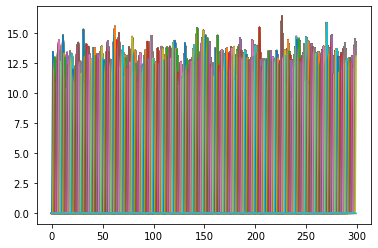

In [8]:
for i in range(b.shape[0]):
    plt.plot(b[i])


In [9]:
@jax.jit
def loss_term(x, Ai, bi, alpha):
    return 1/2*jnp.sum(jnp.conj(Ai@x-bi)*(Ai@x-bi)) + alpha * jnp.sum(jnp.conj(x)*x)

@jax.jit
def loss_sum(x, A, b, alpha):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0, None))(x, A, b, alpha))

@jax.jit
def grad_term(x, Ai, bi, alpha):
    return jax.grad(loss_term)(x, Ai, bi, alpha)



In [10]:
#print(loss_term(x0,A[0],b[0], 1))
#print(loss_sum(x0, A, b, 1))
#print(grad_term(x0,A[0],b[0], 1))

### "Global" parameters

In [149]:
alpha = 1e-2
b1sol = b[0,1]/(1+alpha*B)

key, subkey = random.split(key)
x_init = random.normal(subkey, x0.shape)

### GD with precon

In [150]:
AA = jnp.sum(jax.vmap(lambda Ai : Ai.T @ Ai, in_axes = 0)(A), axis = 0)

D = jnp.diag(AA)+d * alpha
u, v = jnp.linalg.eigh(AA + d*alpha *jnp.eye(d))

100.66666666666667


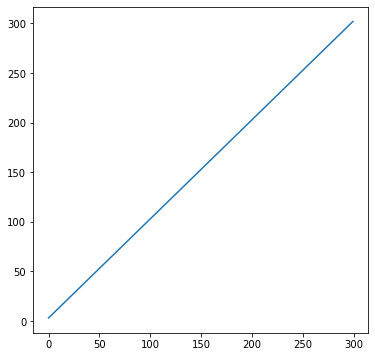

In [151]:
plt.plot(u)
print(u[-1]/u[0])

In [152]:
P = 1/D
#P = jnp.ones(x0.shape)

In [153]:
x_gd = x_init

x_gd_all = [x_gd]
cost_gd = [loss_sum(x_gd, A, b, alpha)]
err_x_gd = [jnp.linalg.norm(x_gd-x0)]
err_b1_gd = [b1sol - x_gd[1]]
2
#eta = 0.001
eta = 1

epochs = 30
for epoch in tqdm(range(epochs)):
    x_gd = x_gd - eta * P * jnp.sum(jax.vmap(grad_term, in_axes = (None, 0, 0, None))(x_gd, A, b, alpha), axis=0)
    cost_gd.append(loss_sum(x_gd, A, b, alpha))
    err_x_gd.append(jnp.linalg.norm(x_gd-x0))
    err_b1_gd.append(b1sol - x_gd[1])
    x_gd_all.append(x_gd)
            
cost_gd = jnp.array(cost_gd)
err_x_gd = jnp.array(err_x_gd)
err_b1_gd = jnp.array(err_b1_gd)
x_gd_all = jnp.array(x_gd_all)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.32it/s]


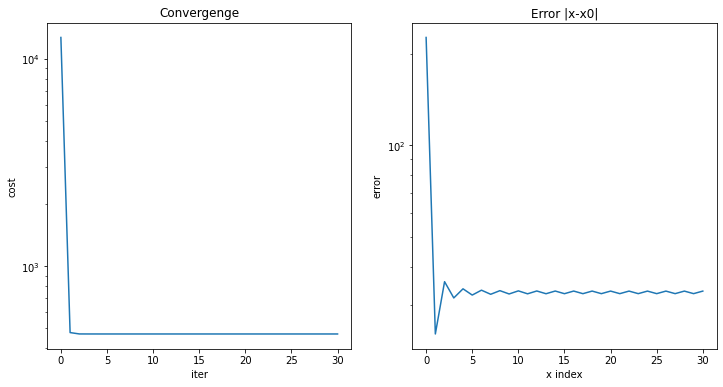

In [154]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost_gd)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')

plt.subplot(122)
plt.semilogy(err_x_gd[:100])

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')

plt.rcParams["figure.figsize"]=6,6

In [155]:
print(x0[0])
print(x_gd[0])
print(x0[0]-x_gd[0])

13.86859505517294
-0.7536161950178671
14.622211250190807


In [156]:
print(b1sol)
print(x0[1])
print(x_gd[1])
print(x0[1]-x_gd[1])
print(err_b1_gd[-1])

3.37139582152871
13.491370420663639
1.9260665059139321
11.565303914749707
1.445329315614778


In [157]:
print(x0[d-1])
print(x_gd[d-1])
print(x0[d-1]-x_gd[d-1])
print(f"sigma={sigma}")

13.113067440328582
12.854619066298287
0.2584483740302943
sigma=0.01


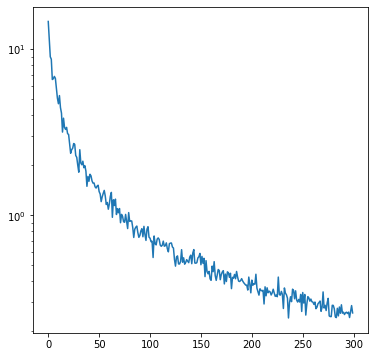

In [158]:
plt.semilogy(x0-x_gd)

### "SGD"

### No precon

In [159]:
P = jnp.ones(x0.shape)

x_sgd = x_init

x_sgd_all_iter = [x_sgd]
x_sgd_all = [x_sgd]

cost_sgd_iter = [loss_sum(x_sgd, A, b, alpha)]
cost_sgd = [loss_sum(x_sgd, A, b, alpha)]

err_x_sgd = [jnp.linalg.norm(x_sgd-x0)]
err_x_sgd_iter = [jnp.linalg.norm(x_sgd-x0)]

err_b1_sgd = [b1sol - x_sgd[1]]
err_b1_sgd_iter = [b1sol - x_sgd[1]]

#eta = 0.1

eta = 1


epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in tqdm(range(B)):
        x_sgd = x_sgd - eta * P * grad_term(x_sgd, A[i], b[i], alpha)
        cost_sgd_iter.append(loss_sum(x_sgd, A, b, alpha))
        err_x_sgd_iter.append(jnp.linalg.norm(x_sgd-x0))
        
        err_b1_sgd_iter.append(b1sol - x_sgd[1])
        x_sgd_all_iter.append(x_sgd)
        
    cost_sgd.append(loss_sum(x_sgd, A, b, alpha))
    err_x_sgd.append(jnp.linalg.norm(x_sgd-x0))
    x_sgd_all.append(x_sgd)
    err_b1_sgd.append(b1sol - x_sgd[1])

            
cost_sgd_iter = jnp.array(cost_sgd_iter)
cost_sgd = jnp.array(cost_sgd)

err_x_sgd = jnp.array(err_x_sgd)

err_b1_sgd_iter = jnp.array(err_b1_sgd_iter)
err_b1_sgd = jnp.array(err_b1_sgd)


x_sgd_all = jnp.array(x_sgd_all)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.67it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.35it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.14it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.74it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.29it/s]


Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.28it/s]


Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.82it/s]


Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.37it/s]


Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.26it/s]


Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.35it/s]


Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.77it/s]


Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.25it/s]


Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.67it/s]


Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.01it/s]


Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.87it/s]


Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.96it/s]


Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.46it/s]


Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.28it/s]


Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.15it/s]


Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.76it/s]


Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.75it/s]


Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.93it/s]


Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.32it/s]


Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.89it/s]


Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.31it/s]


Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.92it/s]


Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.58it/s]


Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.60it/s]


Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.63it/s]


Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.41it/s]


### Precon

In [160]:
P = 1/D
x_sgd_p = x_init

x_sgd_p_all_iter = [x_sgd_p]
x_sgd_p_all = [x_sgd_p]

cost_sgd_p_iter = [loss_sum(x_sgd_p, A, b, alpha)]
cost_sgd_p = [loss_sum(x_sgd_p, A, b, alpha)]

err_x_sgd_p = [jnp.linalg.norm(x_sgd_p-x0)]
err_x_sgd_p_iter = [jnp.linalg.norm(x_sgd_p-x0)]

err_b1_sgd_p = [b1sol - x_sgd_p[1]]
err_b1_sgd_p_iter = [b1sol - x_sgd_p[1]]

#eta = 0.1

eta = 10


epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in tqdm(range(B)):
        x_sgd_p = x_sgd_p - eta * P * grad_term(x_sgd_p, A[i], b[i], alpha)
        cost_sgd_p_iter.append(loss_sum(x_sgd_p, A, b, alpha))
        err_x_sgd_p_iter.append(jnp.linalg.norm(x_sgd_p-x0))
        
        err_b1_sgd_p_iter.append(b1sol - x_sgd_p[1])
        x_sgd_p_all_iter.append(x_sgd_p)
        
    cost_sgd_p.append(loss_sum(x_sgd_p, A, b, alpha))
    err_x_sgd_p.append(jnp.linalg.norm(x_sgd_p-x0))
    x_sgd_p_all.append(x_sgd_p)
    err_b1_sgd_p.append(b1sol - x_sgd_p[1])

            
cost_sgd_p_iter = jnp.array(cost_sgd_p_iter)
cost_sgd_p = jnp.array(cost_sgd_p)

err_x_sgd_p = jnp.array(err_x_sgd_p)

err_b1_sgd_p_iter = jnp.array(err_b1_sgd_p_iter)
err_b1_sgd_p = jnp.array(err_b1_sgd_p)


x_sgd_p_all = jnp.array(x_sgd_p_all)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.10it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.72it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 92.11it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.61it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.27it/s]


Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.14it/s]


Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.10it/s]


Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.34it/s]


Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.12it/s]


Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.56it/s]


Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.29it/s]


Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.89it/s]


Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.12it/s]


Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.53it/s]


Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.45it/s]


Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.24it/s]


Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.03it/s]


Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.09it/s]


Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.89it/s]


Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.58it/s]


Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 88.17it/s]


Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.07it/s]


Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.65it/s]


Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.81it/s]


Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.01it/s]


Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.54it/s]


Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.43it/s]


Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.15it/s]


Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.81it/s]


Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.08it/s]


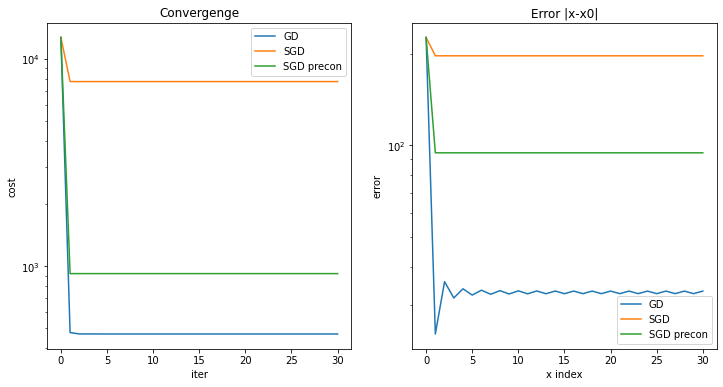

In [161]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost_gd)
plt.semilogy(cost_sgd)
plt.semilogy(cost_sgd_p)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')
plt.legend(['GD', 'SGD', 'SGD precon'])

plt.subplot(122)
plt.semilogy(err_x_gd)
plt.semilogy(err_x_sgd)
plt.semilogy(err_x_sgd_p)

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')
plt.legend(['GD', 'SGD', 'SGD precon'])

plt.rcParams["figure.figsize"]=6,6

In [162]:
print(x0[0])
print(x_sgd[0])
print(x0[0]-x_sgd[0])

13.86859505517294
-8.162655264465112e-80
13.86859505517294


In [163]:
print(b1sol)
print(x0[1])
print(x_sgd[1])
print(x0[1]-x_sgd[1])
print(err_b1_sgd[-1])

3.37139582152871
13.491370420663639
0.03209561447595942
13.459274806187679
3.3393002070527507


In [164]:
print(x0[d-1])
print(x_sgd[d-1])
print(x0[d-1]-x_sgd[d-1])
print(f"sigma={sigma}")

13.113067440328582
12.5947032444308
0.5183641958977816
sigma=0.01


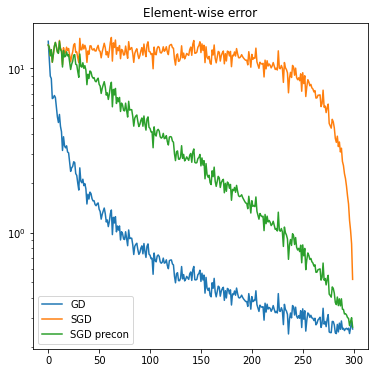

In [165]:
plt.semilogy(jnp.abs(x0-x_gd))
plt.semilogy(x0-x_sgd)
plt.semilogy(x0-x_sgd_p)


plt.title('Element-wise error')
plt.legend(['GD', 'SGD', 'SGD precon'])

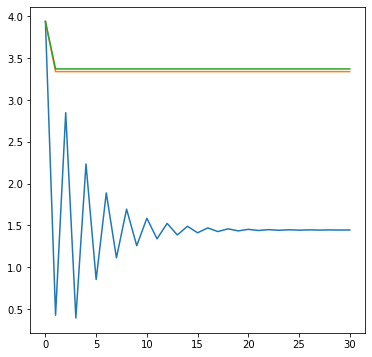

In [166]:
plt.plot(jnp.abs(err_b1_gd))
plt.plot(jnp.abs(err_b1_sgd))
plt.plot(jnp.abs(err_b1_sgd_p))

(31, 300)


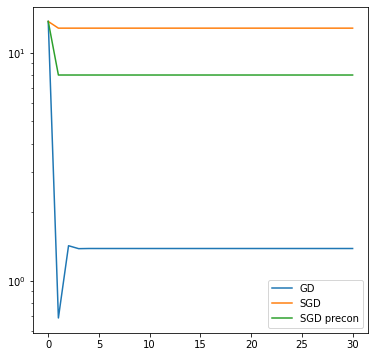

In [186]:
print(x_sgd_p_all.shape)

idx = 50
plt.semilogy(jnp.abs(x_gd_all[:,idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_all[:,idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_p_all[:,idx] - x0[idx]))

plt.legend(['GD', 'SGD', 'SGD precon'])

In [168]:
idx = 50
print(sigma)
print(alpha)
print(x0[idx])
print(x_gd_all[9,idx]- x_sgd_p_all[9,idx])

0.01
0.01
12.918022291069274
6.609885317700823


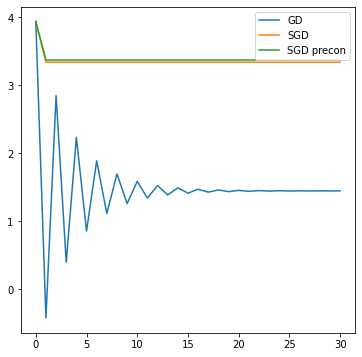

In [187]:
plt.plot(err_b1_gd)
plt.plot(err_b1_sgd)
plt.plot(err_b1_sgd_p)
plt.legend(['GD', 'SGD', 'SGD precon'])

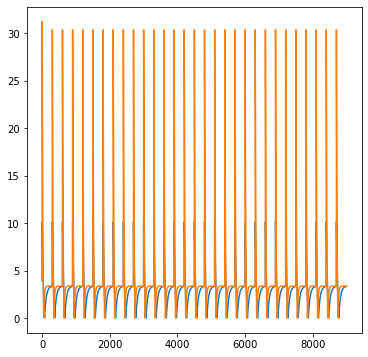

In [189]:
plt.plot(jnp.abs(err_b1_sgd_iter))


In [ ]:
plt.plot(jnp.abs(err_b1_sgd_p_iter))

In [190]:
x_gd_all.shape

(31, 300)

In [191]:
b[0,1]

DeviceArray(13.48558329, dtype=float64)

In [192]:
err_b1_sgd_iter

DeviceArray([  3.93893079, -10.12553816,  -9.85559948, ...,   3.33797681,
               3.33864519,   3.33930021], dtype=float64)